# ML Pipeline for the CH Parents

## Purpose of this notebook
- [x]  Prepare dataframe for ML
- [x]  Create baseline models
    - [x]  User-based
        - [x]  last known assessment *of this user*
        - [x]  all known assessments *of this user*
    - [x]  Assessment-based
        - [x]  last known assessment
        - [x]  all assessments
- [x]  Perform different split approaches to get different model solutions
    - [x]  User-Cut
    - [x]  Time-Cut
    - [x]  User-wise
    - [x]  Average-user
- [x]  Evalulate all approaches in one table in terms of performance and robustness
- [ ] Review approaches

## Prepare dataframe for ML

In [1]:
# imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier

# to import own modules, a workaround - assuming the curent working directory is the folder (your/local/path/UsAs/src/d01_analysis
import sys
sys.path.insert(0, "../..")

from src.d00_utils import helpers, process_rki_parent_dataset

In [2]:
# suppress annoying warnings
pd.options.mode.chained_assignment = None

In [3]:
# read in df
df = pd.read_csv('../../data/d02_processed/rki_parent.csv')
df.set_index('answer_id', inplace=True)

In [4]:
df.phq9_i.describe()

count    9553.000000
mean        0.201612
std         0.536531
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: phq9_i, dtype: float64

In [5]:
df.head()

,questionnaire_id,user_id,created_at,pers,a_ort,a_lohn,covid1,covid2,covid3,mhem1,...,schlaf_7,sport2,alk_1,alk_2,feedback,phqpd_b,phqpd_c,phqpd_d,phq9_score,phq9_score_t1
answer_id,,,,,,,,,,,,,,,,,,,,,
19,2,7,2020-07-23 14:12:43,1,1,0,0,0,0,2,...,0,3,0,NaN,1.0,NaN,NaN,NaN,0,0.0
22,2,7,2020-07-24 14:14:17,1,1,0,0,0,0,2,...,0,3,0,NaN,1.0,NaN,NaN,NaN,0,0.0
115,2,152,2020-07-28 09:58:47,1,2,0,0,0,0,1,...,0,4,1,0.0,1.0,NaN,NaN,NaN,0,0.0
155,2,140,2020-07-28 20:41:39,1,2,1,0,0,0,3,...,0,2,4,NaN,1.0,NaN,NaN,NaN,0,0.0
162,2,114,2020-07-29 04:08:12,1,2,0,0,0,0,2,...,1,1,3,1.0,1.0,NaN,NaN,NaN,1,0.0


Define test data to evaluate all approaches on the same testset.

20 % of the users shall be taken for test, 80 % for trying out different approaches.

In [6]:
df.describe()

,questionnaire_id,user_id,pers,a_ort,a_lohn,covid1,covid2,covid3,mhem1,pt_aktuell2,...,schlaf_7,sport2,alk_1,alk_2,feedback,phqpd_b,phqpd_c,phqpd_d,phq9_score,phq9_score_t1
count,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,9607.000000,...,9607.000000,9607.000000,9607.000000,5514.000000,9607.000000,1994.000000,1784.000000,1752.000000,9607.000000,9607.000000
mean,7.190382,3410.559592,1.002394,1.736859,0.199750,0.085354,0.356407,0.070886,2.285209,1.753305,...,0.857292,2.857812,1.085563,0.758433,0.629957,0.604313,0.470852,0.503995,0.977204,0.975018
std,3.818967,2851.269369,0.048873,0.686624,0.476786,0.398050,0.747796,0.256647,0.816020,0.538477,...,1.093931,1.370618,1.239810,0.941634,0.482841,0.489120,0.499290,0.500127,1.160008,1.162518
min,2.000000,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1007.500000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,2882.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,...,0.000000,3.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
75%,10.000000,5233.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,...,1.000000,4.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,10.000000,11376.000000,2.000000,3.000000,2.000000,2.000000,2.000000,1.000000,5.000000,2.000000,...,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000


In [7]:
# create a random_state
random_state = 1994
seed = 2023

In [8]:
# first 80 % of users into train, second 20 % into test
df_train, df_test = helpers.create_train_and_test_set(df, sort_users=True, seed=seed)

In [9]:
# define features and target
features = process_rki_parent_dataset.get_features(df)
target = 'phq9_score_t1'
time_col = 'created_at'
user_col = 'user_id'

# set up for classification - target is already categorical, no bins or LabelEncoding required
bins = None
LE = None

# preare dataset and model
model, X_train, X_test, y_train, y_test, _ = helpers.prepare_and_instantiate(df_train, df_test, features, target, bins, LE, fit=False, cut=False)

# Create mapping
mapping = {0: 'None',
           1: 'Mild',
           2: 'Moderate',
           3: 'Moderate-to-Severe',
           4: 'Severe'}

# cross validation setup
n_splits = 5
test_size = 1/n_splits

# preprare results dic
approaches = helpers.get_approaches()
results_dic = {approach: {'f1':None, 'std':None} for approach in approaches}



In [10]:
approaches

['bl_user_based_last',
 'bl_user_based_all',
 'bl_assessment_based_last',
 'bl_assessment_based_all',
 'user_cut',
 'time_cut',
 'user_wise',
 'average_user']

## Create baseline models

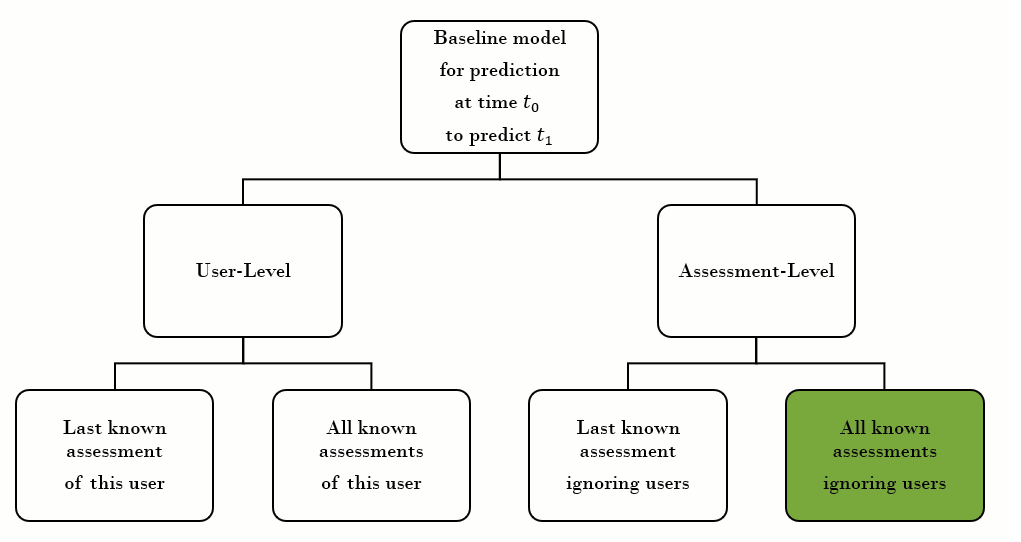

Approach:	 all
0.0    736
1.0    466
2.0    222
3.0    126
4.0     68
Name: phq9_score_t1, dtype: int64
0.0    755
1.0    440
2.0    215
3.0    136
4.0     72
Name: phq9_score_t1, dtype: int64
0.0    758
1.0    442
2.0    195
3.0    130
4.0     93
Name: phq9_score_t1, dtype: int64
0.0    769
1.0    445
2.0    217
3.0    133
4.0     54
Name: phq9_score_t1, dtype: int64
0.0    786
1.0    461
2.0    201
3.0    107
4.0     63
Name: phq9_score_t1, dtype: int64
Performance within TRAIN
Assessment approach
f1_weighted mean 	 0.3009142221589704
standarddeviation 	 0.011073975544990877
#################################################
User approach
f1_weighted mean 	 0.6675050660851507
standarddeviation 	 0.005675707194031125
Performance within TEST
Final score assessment approach:	 0.3165092596635912


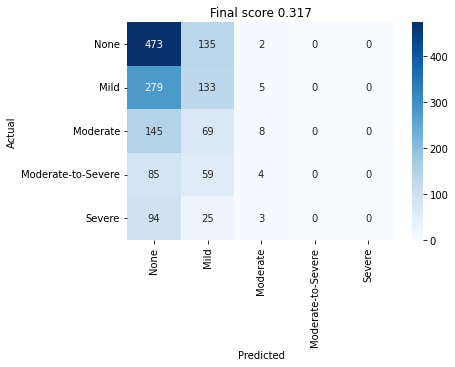

Final score user approach:	 0.6982994375086824


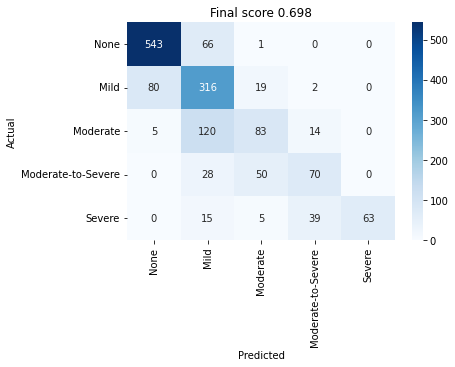

Approach:	 last
0.0    736
1.0    466
2.0    222
3.0    126
4.0     68
Name: phq9_score_t1, dtype: int64
0.0    755
1.0    440
2.0    215
3.0    136
4.0     72
Name: phq9_score_t1, dtype: int64
0.0    758
1.0    442
2.0    195
3.0    130
4.0     93
Name: phq9_score_t1, dtype: int64
0.0    769
1.0    445
2.0    217
3.0    133
4.0     54
Name: phq9_score_t1, dtype: int64
0.0    786
1.0    461
2.0    201
3.0    107
4.0     63
Name: phq9_score_t1, dtype: int64
Performance within TRAIN
Assessment approach
f1_weighted mean 	 0.3239339224410569
standarddeviation 	 0.012970909939273932
#################################################
User approach
f1_weighted mean 	 0.6034568624051714
standarddeviation 	 0.008048318185686165
Performance within TEST
Final score assessment approach:	 0.3134099138466827


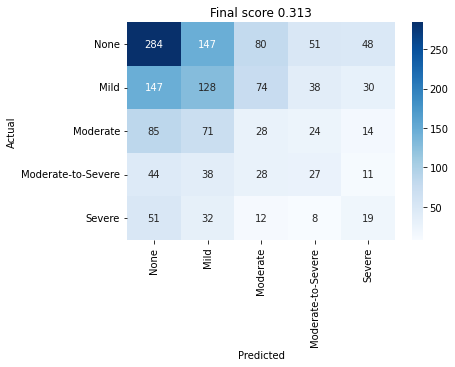

Final score user approach:	 0.671352043917892


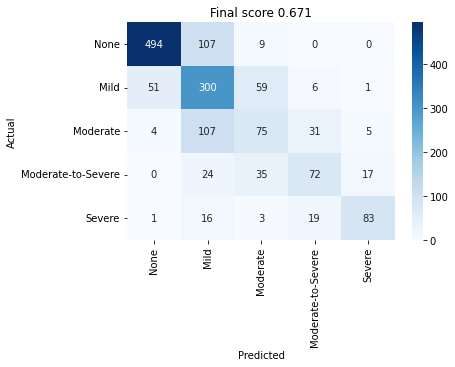

In [11]:
# instantiate model
model = helpers.baseline_model()

# define constants
for approach in ['all', 'last']:
    print('Approach:\t', approach)

    # train model in cross validation
    cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    scores_a = []
    scores_u = []
    for _, val_indices in cv.split(df_train):

        # divide all train data into folds
        df_train_val_fold = df_train.iloc[val_indices, :]

        # get baseline prediction
        y_pred_a = model.get_baseline_assessment_prediction(data=df_train_val_fold, target_name=target, 
                                                            approach=approach, time_col = time_col, mode=True)
        y_pred_u = model.get_baseline_user_prediction(data=df_train_val_fold, target_name=target, 
                                                      approach=approach, time_col = time_col, mode=True)
        y_true = df_train_val_fold[target]

        assert y_pred_a.shape[0] == y_true.shape[0]
        print(y_true.value_counts(dropna=False))

        # calculate score
        f1_score_test_a = f1_score(y_true, y_pred_a, average='weighted')
        f1_score_test_u = f1_score(y_true, y_pred_u, average='weighted')
        scores_a.append(f1_score_test_a)
        scores_u.append(f1_score_test_u)

    # validate model
    print('Performance within TRAIN')
    print('Assessment approach')
    print('f1_weighted mean \t', np.array(scores_a).mean())
    print('standarddeviation \t', np.array(scores_a).std())
    print('#################################################')
    print('User approach')
    print('f1_weighted mean \t', np.array(scores_u).mean())
    print('standarddeviation \t', np.array(scores_u).std())
    # evaluate on test set

    # assessment------------------------------------------------------------------------------
    y_pred_a = model.get_baseline_assessment_prediction(data=df_test, target_name=target, 
                                                        approach=approach, mode=True).values

    f1_score_test_a = f1_score(y_test, y_pred_a, average='weighted')
    std = np.array(scores_a).std()
    final_score_a = f1_score_test_a - 0.5 * std

    print('Performance within TEST')
    print('Final score assessment approach:\t', final_score_a)
    
    results_dic[f'bl_assessment_based_{approach}']['f1'] = final_score_a
    results_dic[f'bl_assessment_based_{approach}']['std'] = std



    # visualize confusion matrix
    # assessment
    helpers.visualize_confusion_matrix(y_test, y_pred_a, mapping, final_score_a)

    # user------------------------------------------------------------------------------------

    y_pred_u = model.get_baseline_user_prediction(data=df_test, target_name=target, approach=approach).values
    f1_score_test_u = f1_score(y_test, y_pred_u, average='weighted')
    std = np.array(scores_u).std()
    final_score_u = f1_score_test_u - 0.5 * std
    
    results_dic[f'bl_user_based_{approach}']['f1'] = final_score_u
    results_dic[f'bl_user_based_{approach}']['std'] = std

    print('Final score user approach:\t', final_score_u)



    helpers.visualize_confusion_matrix(y_test, y_pred_u, mapping, final_score_u)

#### Assessment approach
 - `last`: #TODO interpret
 - `all`:  #TODO interpret
 
#### User approach
 - `last`: #TODO interpret
 - `all`:  #TODO interpret

## Perform different split approaches to get different model solutions

### Approach | Assessment | User-Cut

Performance within train
f1_weighted mean  0.6579585299600818
standarddeviation  0.0374873292381105


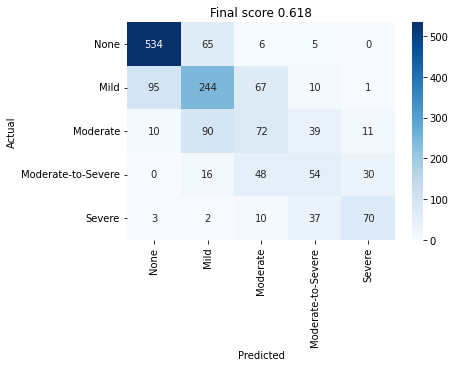

In [12]:
# instantiate model
model = RandomForestClassifier(random_state=random_state)

# split by user
df_train, df_test = helpers.create_train_and_test_set(df, sort_users=True, seed=seed)

# get data
model, X_train, X_test, y_train, y_test, _ = helpers.prepare_and_instantiate(df_train, df_test, features, target, bins, LE, fit=False, cut=False)

# train model
cv = GroupKFold(n_splits = n_splits)# in each fold, user groups are distinct
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted', groups=df_train.user_id)

# validate model
print('Performance within train')
print('f1_weighted mean ', scores.mean())
print('standarddeviation ', scores.std())

y_pred, f1_final = helpers.fit_and_calc_score(model, X_train, X_test, y_train, y_test, scores)

# visualize confusion matrix
helpers.visualize_confusion_matrix(y_test, y_pred, mapping, f1_final)

# write to results dict
approach = 'user_cut'
results_dic[approach]['f1'] = f1_final
results_dic[approach]['val-mean'] = scores.mean()
results_dic[approach]['std'] = scores.std()

With the standard random shuffle and ignoring user aspects, the model is better than random guessing. However, without having the information that user groups exist, the score is well below 60 %.

### Approach | Assessment | Time-cut

Performance within train
f1_weighted mean  0.699
standarddeviation  0.012


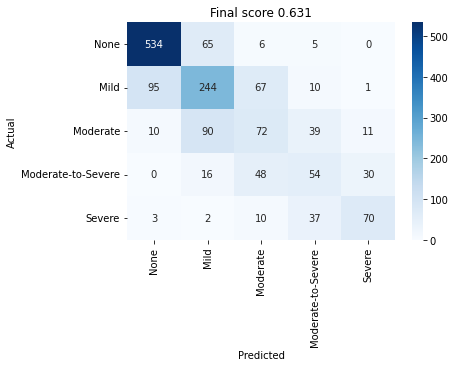

In [13]:
# create new model instance
model, _, _, _, _, _ = helpers.prepare_and_instantiate(df_train, df_test, features, target, bins, LE, fit=False, cut=False)

# create a group column. Each group belongs to a dategroup. The first 20% of the train data belong to date_group_1, the next 20% belong to date_group_2, and so on.
groups = np.sort(np.random.randint(low=1, high=5+1, size = df_train.shape[0]))

# train model
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted', groups=groups)

# validate model
print('Performance within train')
print('f1_weighted mean ', round(scores.mean(), 3))
print('standarddeviation ', round(scores.std(), 3))

y_pred, f1_final = helpers.fit_and_calc_score(model, X_train, X_test, y_train, y_test, scores)

# visualize confusion matrix
helpers.visualize_confusion_matrix(y_test, y_pred, mapping, f1_final)

# write to results dict
approach = 'time_cut'
results_dic[approach]['f1'] = f1_final
results_dic[approach]['val-mean'] = scores.mean()
results_dic[approach]['std'] = scores.std()

Making a precise differentiation with evenly sized time chunks, the model improves to the random approach. This might be due to the fact that some users joined the study later, so there was an indirect grouped kfold validation. The score improves from the random approach by 3%-points.

### Approach | User | Average-user

For each assesment, check the user id and calculate the mean of all answers known by this user so far. These mean replace the reported assessments.

Performance within train
f1_weighted mean  0.6672566761880594
standarddeviation  0.03785711344101287


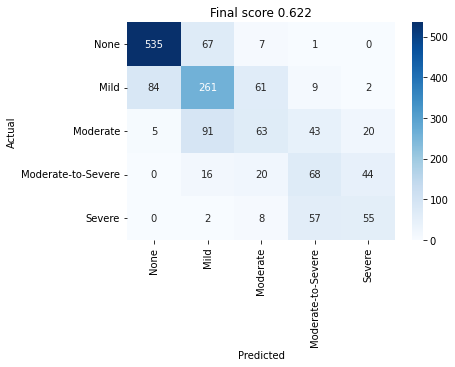

In [14]:
# calculate grouped cumulative means for all assessments of all users3
df_train_avg_user = helpers.calc_cum_mean(df_train, features, user_id='user_id')
df_test_avg_user = helpers.calc_cum_mean(df_test, features, user_id='user_id')

# prepare data and model
model, X_train, X_test, y_train, y_test, LE = helpers.prepare_and_instantiate(df_train_avg_user, df_test_avg_user, features, target, bins, LE, fit=False, cut=False)

# train model
cv = GroupKFold(n_splits=n_splits)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted', groups=df_train_avg_user.user_id)

# validate model
print('Performance within train')
print('f1_weighted mean ', scores.mean())
print('standarddeviation ', scores.std())

# fit and calculate
y_pred, f1_final = helpers.fit_and_calc_score(model, X_train, X_test, y_train, y_test, scores)

# visualize confusion matrix
helpers.visualize_confusion_matrix(y_test, y_pred, mapping, f1_final)

# write to results dict
approach = 'average_user'
results_dic[approach]['f1'] = f1_final
results_dic[approach]['val-mean'] = scores.mean()
results_dic[approach]['std'] = scores.std()

# TODO Interpet

## Approach | User | User-wise-model

In [15]:
user_dfs = helpers.create_user_dfs(df_test, min_assessments=10)

mean within train for per user: 0.7188126399255966
std within train for per user: 0.32616629565038596


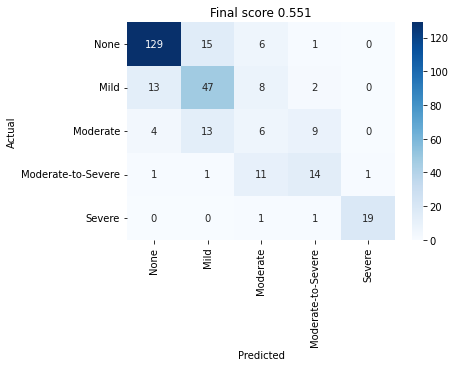

In [16]:
y_preds, y_tests, all_scores, all_f1s_final, n_assessments_training= [], [], [], [], []


for i, user_df in enumerate(user_dfs):
    
    # sort by assessment
    user_df = user_df.sort_values(by=time_col)
    
    # create train and test assessments
    # 70 % position idx
    idx70 = int("{:.0f}".format(user_df.shape[0]*.7))
    train_assessments = user_df.iloc[:idx70, :]
    test_assessments  = user_df.iloc[idx70:, :]
    # preare dataset and model
    model, X_train, X_test, y_train, y_test, LE = helpers.prepare_and_instantiate(train_assessments, test_assessments, features, target, bins, LE, fit=False, cut=False)
    
    cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted')

    # fit and calculate
    y_pred, f1_final = helpers.fit_and_calc_score(model, X_train, X_test, y_train, y_test, scores)

    all_f1s_final.append(f1_final)
    all_scores.extend(scores)
    y_tests.extend(y_test)
    y_preds.extend(y_pred)

# calculate final score
_, f1_final = helpers.calc_final_score(np.array(all_scores), y_preds, y_tests)

# print results
print('mean within train for per user:', np.array(all_scores).mean())
print('std within train for per user:', np.array(all_scores).std())

# visualize confusion matrix
helpers.visualize_confusion_matrix(y_tests, y_preds, mapping, f1_final)    

# write to results dict
approach = 'user_wise'
results_dic[approach]['f1'] = f1_final
results_dic[approach]['std'] = scores.std()

## Evalulate all approaches in one table in terms of performance and robustness

In [18]:
res_df = pd.DataFrame.from_dict(results_dic, orient="index").sort_values(by='f1')
res_df.to_csv(f'../../results/tables/approaches/sorted_users/single_dataset/rki_parent.csv', index_label='approach')
res_df

,f1,std,val-mean
bl_assessment_based_last,0.313410,0.012971,NaN
bl_assessment_based_all,0.316509,0.011074,NaN
user_wise,0.550553,0.000000,NaN
user_cut,0.617935,0.037487,0.657959
average_user,0.622417,0.037857,0.667257
time_cut,0.630523,0.012311,0.698672
bl_user_based_last,0.671352,0.008048,NaN
bl_user_based_all,0.698299,0.005676,NaN
